# **Accumulated squared momentum for static partons in Glasma**

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"
su_group = os.environ["GAUGE_GROUP"]
quark = 'charm'

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.kappa as kappa
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
from tqdm.notebook import tqdm

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [2]:
# define hbar * c in units of GeV * fm
hbarc = 0.197326 

def compute(p):    

    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    formt = int(p['TFORM'] / a) * p['DTS']

    all_px, all_py, all_pz = [], [], []
    
    # event loop
    for e in range(p['NE']):
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        initial.init(s, va, vb)
        
        kappa_tforce = kappa.TransportedForce(s)
        px, py, pz = [], [], []
        tau = []

        if use_cuda:
            s.copy_to_device()
            kappa_tforce.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
        
        with tqdm(total=(maxt-formt), file=sys.stdout) as pbar:
            for t in range(maxt):
                core.evolve_leapfrog(s)
                
                if t>= formt:
                    if t % p['DTS'] == 0:
                        if use_cuda:
                            kappa_tforce.copy_mean_to_host()

                        # unit factors (GeV^2)
                        units = E0 ** 2 / (s.g ** 2)

                        # color factors (for quarks)
                        Nc = core.su.NC
                        f = 2 * s.g ** 2 / (2 * Nc)
                        px.append(kappa_tforce.p_perp_mean[0] * units * f)
                        py.append(kappa_tforce.p_perp_mean[1] * units * f)
                        pz.append(kappa_tforce.p_perp_mean[2] * units * f)

                        tau.append(t*a/p['DTS'])
                        
                        if use_cuda:
                            kappa_tforce.copy_mean_to_device()

                    kappa_tforce.compute()

                    pbar.set_description('Event {:3d} | {:.2f} GB / {:.2f} GB'.format(e,
                                                                                    meminfo[0] / 1024 ** 3,
                                                                                    meminfo[1] / 1024 ** 3))
                    pbar.update(1)
        
        px = np.array(px)
        py = np.array(py)
        pz = np.array(pz)

        filename = 'tauform_' + str(p['TFORM']) + '_ev_' + str(e) + '.npz'
        np.savez(filename, px=px, py=py, pz=pz, tau=tau)

        all_px.append(px)
        all_py.append(py)
        all_pz.append(pz)

    px_mean, px_std = np.mean(all_px, axis=0), np.std(all_px, axis=0)
    py_mean, py_std = np.mean(all_py, axis=0), np.std(all_py, axis=0)
    pz_mean, pz_std = np.mean(all_pz, axis=0), np.std(all_pz, axis=0)

    filename = 'tauform_' + str(p['TFORM']) + '_mean.npz'
    np.savez(filename, px_mean=px_mean, px_std=px_std, py_mean=py_mean, py_std=py_std, pz_mean=pz_mean, pz_std=pz_std, tau=tau)
    
    if use_cuda:
        cuda.current_context().deallocations.clear()

In [3]:
current_path = os.getcwd() 
results_folder = 'results'
check_results_folder = os.path.isdir(results_folder)
if not check_results_folder:
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'
os.chdir(results_path)

kappa_folder = 'pb+pb_5020gev_' + su_group + '_kappa'
check_kappa_folder = os.path.isdir(kappa_folder)
if not check_kappa_folder:
    os.makedirs(kappa_folder)
kappa_path = results_path + '/' + kappa_folder + '/'
os.chdir(kappa_path)

def run_simulation():
    p = {
        'L':    L,               # transverse size [fm]
        'N':    N,            # lattice size
        'DTS':  DTS,              # time steps per transverse spacing
        'TMAX': tau_s,         # max. proper time (tau) [fm/c]

        'G':    g,               # YM coupling constant
        'MU':   mu,              # MV model parameter [GeV]
        'M':    m,               # IR regulator [GeV]
        'UV':   10.0,       # UV regulator [GeV]
        'NS':   ns,              # number of color sheets

        'NE':   20,              # number of events
        'TFORM': tau_form,      # formation time
    }
    
    compute(p)

In [10]:
# Length of simulation box [fm]
L = 10
# Number of lattice sites
N = 512
# Simulation time [fm/c]
tau_s = 2.0
# Time step
DTS = 8
# Formation time [fm/c]
if quark=='charm':
    tau_form = 0.06
elif quark=='beauty':
    tau_form = 0.02
elif quark=='infmass':
    tau_form = 0.00

# MV model parameters for Pb-Pb 5.02 TeV
ns = 50
factor = 0.8
A = 207
sqrts = 5020

Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)		
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))		
mu = Qs / (g**2 * factor)	
m = 0.1 * g**2 * mu   

# run_simulation()

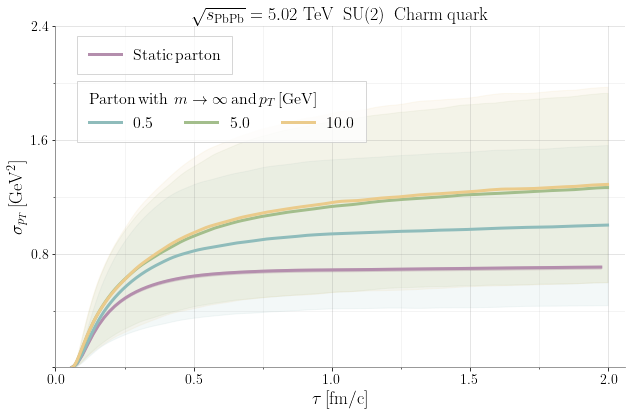

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pickle

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot(111)

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)

if su_group=='su2':
    if quark=='charm':
        plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}\,\,\,\mathrm{Charm\,quark}$', size = 18)
        ax.set_xlim(0,2.06)
        ax.set_ylim(0,2.4)
        ax.yaxis.set_major_locator(MultipleLocator(0.8))
        ax.yaxis.set_minor_locator(MultipleLocator(0.4))
    if quark=='beauty':
        plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}\,\,\,\mathrm{Beauty\,quark}$', size = 18)
        ax.set_xlim(0,2.06)
        ax.set_ylim(0,3.4)
        ax.yaxis.set_major_locator(MultipleLocator(0.8))
        ax.yaxis.set_minor_locator(MultipleLocator(0.4))
    if quark=='infmass':
        plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
        ax.set_xlim(0,2.06)
        ax.set_ylim(0,3)
        ax.yaxis.set_major_locator(MultipleLocator(0.8))
        ax.yaxis.set_minor_locator(MultipleLocator(0.4))

    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    
elif su_group=='su3':
    if quark=='charm':
        plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}\,\,\,\mathrm{Charm\,quark}$', size = 18)
    if quark=='beauty':
        plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}\,\,\,\mathrm{Beauty\,quark}$', size = 18)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
plt.grid(b=True, which='minor', color='gray', alpha=0.1)

os.chdir(kappa_path)
if quark=='massinf':
    tau_form = 0.0

# tau_form = 0.0
data = np.load('tauform_' + str(tau_form) + '_mean.npz')
px_mean, px_std = data["px_mean"], data["px_std"]
py_mean, py_std = data["py_mean"], data["py_std"]
tau = data["tau"]

Nc = core.su.NC 
# sigmap_mean = Nc * (px_mean+py_mean)
# sigmap_std = Nc * (px_std+py_std)
sigmap_mean = (px_mean+py_mean)
sigmap_std = (px_std+py_std)

s, = ax.plot(tau, sigmap_mean, '-', color = '#B48EAD', markersize = 0, linewidth = 3, label=r'$\mathrm{Static\,parton}$')
ax.fill_between(tau, sigmap_mean-sigmap_std/2, sigmap_mean+sigmap_std/2, color = '#B48EAD', alpha=0.3)
h1 = [s]
lab1 = [ h.get_label() for h in h1]
leg1 = plt.legend(h1,lab1, fontsize = 16, loc = 'upper left', ncol=2, bbox_to_anchor=(0.033,0.98))
leg1.get_frame().set_boxstyle('square')

pTs = [0.5, 5.0, 10.0]
sigmapt_mean, sigmapt_std = {}, {}

hq = [None] * 3
for pT in pTs:
    # wong_folder = 'pb+pb_5020gev_su2_pT_' + str(pT) + '_wilson_lines_' + quark
    wong_folder = 'pb+pb_5020gev_su2_pT_' + str(pT) + '_' + quark
    wong_path = results_path + wong_folder + '/' 
    os.chdir(wong_path)
    data = pickle.load(open('avg.npz', "rb"))
    sigmapt_mean[str(pT)], sigmapt_std[str(pT)], tau = data['sigmapt_mean'], data['sigmapt_std'], data['tau']

colors = ['#8FBCBB', '#A3BE8C', '#EBCB8B']
pTs = [0.5, 5.0, 10.0]
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

i = 0
for pT in pTs:
    hq[i], = ax.plot(tau[1:len(tau)], sigmapt_mean[str(pT)], '-', color = colors[i], markersize = 0, linewidth = 3, label=labels[i])
    ax.fill_between(tau[1:len(tau)], sigmapt_mean[str(pT)]-sigmapt_std[str(pT)]/2, sigmapt_mean[str(pT)]+sigmapt_std[str(pT)]/2, color = colors[i], alpha=0.1)
    i=i+1
h2 = [hq[0], hq[1], hq[2]]

lab2 = [h.get_label() for h in h2]
leg2 = plt.legend(h2, lab2, fontsize = 16, loc = 'upper left', ncol=3, bbox_to_anchor=(0.033,0.85))
leg2.get_frame().set_boxstyle('square')
leg2.set_title(r'$\mathrm{Parton\,with\,}\,m\rightarrow\infty\,\mathrm{and}\,p_T\,[\mathrm{GeV}]$') 
leg2.get_title().set_fontsize('16')
leg2._legend_box.align = "left"
plt.gca().add_artist(leg1)  



plt.tight_layout()
os.chdir(current_path)
# plt.savefig('plots/sigmapT_kappa_' + su_group + '_pb+pb_5020gev_' + quark + '.png', dpi = 300,  facecolor='white', transparent=False)
plt.show()